In [1]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3
import geometry_v2
import cpb
import feedexp3_v2
import bpm
import random_algo
import feedexp3_v3

def evaluate_parallel(nbCores, n_folds, horizon, alg, game):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon)
    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''
  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class Evaluation:

    def __init__(self, horizon ):
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution
    
    def get_outcomes(self, game, job_id):
        np.random.seed(job_id)
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, jobid):

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]
            feedback =  self.get_feedback( game, action, outcome )


            alg.update(action, feedback, outcome)
            # print('t', t, 'action', action, 'outcome', outcome, 'action',action, 'eta', alg.eta, 'gamma', alg.gamma, 'pbt',alg.pbt )
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        return action_counter

def eval_cpbvanilla_parallel(task, nbCores, n_folds, horizon, alpha):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''
  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)


In [16]:
n_cores = 16
n_folds = 25
horizon = 200

outcome_distribution =  {'spam':0.05,'ham':0.95}

In [5]:
game = games.apple_tasting(False, outcome_distribution)
print('optimal action', game.i_star)
alg = cpb.CPB( game, horizon )
task = Evaluation(horizon)
task.eval_policy_once(alg,game,1)

optimal action 1


array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
          3.,   3.,   3.,   3.,   3.,   3.,   3.,   4.,   4.,   4.,   4.,
          4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
          4.,   4.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
         20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
         31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
         42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
         53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
         64.,  65.,  66.,  67.,  68., 

In [17]:

game = games.apple_tasting(False, outcome_distribution)

alg = cpb.CPB(  game, horizon,)
result0 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result0,0) 
std0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result0,0) 
plt.plot(   regret0 , label = 'CPB', color = 'purple' )
plt.fill_between( range(horizon) ,  regret0    , regret0 + std0 , color = 'purple' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, )
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Bianchi', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

alg = feedexp3_v3.FeedExp3(  game, horizon, )
result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3,0) 
std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3,0) 
plt.plot(   regret3  , label = 'Piccolboni', color = 'green' )
plt.fill_between( range(horizon) ,  regret3    , regret3 + std3 , color = 'green' , alpha = 0.2)

alg = bpm.BPM(  game, horizon,  [0.5,0.5], np.identity(2) )
result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3, 0) 
std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3, 0) 
plt.plot(   regret3 , label = 'BPM-least', color = 'blue' )
plt.fill_between( range(horizon) ,  regret3 , regret3 + std3 , color = 'blue' , alpha = 0.2)

plt.legend()

nbCores: 16 nbFolds: 25 Horizon: 200
nbCores: 16 nbFolds: 25 Horizon: 200
nbCores: 16 nbFolds: 25 Horizon: 200
n-actions 2 n-outcomes 2 alphabet 2
nbCores: 16 nbFolds: 25 Horizon: 200


nbCores: 16 nbFolds: 25 Horizon: 200
nbCores: 16 nbFolds: 25 Horizon: 200
nbCores: 16 nbFolds: 25 Horizon: 200
n-actions 2 n-outcomes 2 alphabet 3
nbCores: 16 nbFolds: 25 Horizon: 200


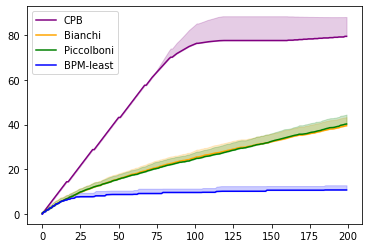

In [11]:
game = games.bandit(False,outcome_distribution)

alg = cpb.CPB(  game, horizon,)
result0 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result0,0) 
std0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result0,0) 
plt.plot(   regret0 , label = 'CPB', color = 'purple' )
plt.fill_between( range(horizon) ,  regret0    , regret0 + std0 , color = 'purple' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, )
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Bianchi', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

alg = feedexp3_v3.FeedExp3(  game, horizon, )
result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3,0) 
std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3,0) 
plt.plot(   regret3  , label = 'Piccolboni', color = 'green' )
plt.fill_between( range(horizon) ,  regret3    , regret3 + std3 , color = 'green' , alpha = 0.2)

alg = bpm.BPM(  game, horizon,  [0.5,0.5], np.identity(2) )
result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3, 0) 
std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3, 0) 
plt.plot(   regret3 , label = 'BPM-least', color = 'blue' )
plt.fill_between( range(horizon) ,  regret3 , regret3 + std3 , color = 'blue' , alpha = 0.2)

plt.legend()

nbCores: 16 nbFolds: 50 Horizon: 2000
nbCores: 16 nbFolds: 50 Horizon: 2000


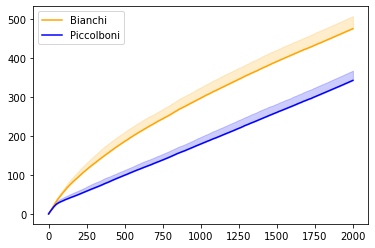

In [18]:
game = games.label_efficient(outcome_distribution)

# alg = random_algo.Random(  game, horizon, )
# result0 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
# regret0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result0,0) 
# std0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result0,0) 
# plt.plot(   regret0 , label = 'Random', color = 'pink' )
# plt.fill_between( range(horizon) ,  regret0    , regret0 + std0 , color = 'pink' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, )
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Bianchi', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

alg = feedexp3_v3.FeedExp3(  game, horizon, )
result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3,0) 
std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3,0) 
plt.plot(   regret3  , label = 'Piccolboni', color = 'blue' )
plt.fill_between( range(horizon) ,  regret3    , regret3 + std3 , color = 'blue' , alpha = 0.2)

# alg = cpb.CPB(  game, horizon,)
# result0 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
# regret0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result0,0) 
# std0 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result0,0) 
# plt.plot(   regret0 , label = 'CPB', color = 'purple' )
# plt.fill_between( range(horizon) ,  regret0    , regret0 + std0 , color = 'purple' , alpha = 0.2)

# alg = bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) )
# result3 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
# regret3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result3, 0) 
# std3 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result3, 0) 
# plt.plot(   regret3 , label = 'BPM-least', color = 'blue' )
# plt.fill_between( range(horizon) ,  regret3 , regret3 + std3 , color = 'blue' , alpha = 0.2)

plt.legend()